# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [318]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Put your markdown formulas here

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [307]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    reg1 = gamma * np.sum(np.abs(w))
    reg2 = beta * np.sum(np.square(w))
    under_log = 1 + np.exp(np.multiply(-y, np.dot(X, w) + w0))

    return (1 / np.shape(X)[0]) * np.log(under_log) + reg1 + reg2

#### 3. [0.25 points] Implement the gradient (as a function)

In [308]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    up = np.exp(np.multiply(-y, np.dot(X, w) + w0))
    down = 1 + np.exp(np.multiply(-y, np.dot(X, w) + w0))

    grad_w0 = (1 / np.shape(X)[0]) * np.dot(up / down, -y)

    derivative_l1 = gamma * np.sign(w)
    derivative_l2 = 2 * beta * w

    grad_w = (1 / np.shape(X)[0]) * np.dot(np.multiply(up / down, -y),  X) + derivative_l1 + derivative_l2

    return grad_w, grad_w0

#### Check yourself

In [309]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)

assert (np.allclose(grad_w,
                    [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                    rtol=1e-2) & np.allclose(grad_w0,
                                             -0.2078231418067844,
                                             rtol=1e-2)
        )

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [310]:
from sklearn.base import BaseEstimator, ClassifierMixin
from numpy import linalg as la

In [311]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state

        self.loss_history = None
        self.w = None
        self.w0 = 0

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.loss_history = []
        w = np.random.normal(0, 1, np.shape(X)[1])
        self.w0 = np.random.normal(0, 1, size=1)
        self.w = w.copy()
        iter_num = 0
        while iter_num < self.max_iter and abs(la.norm(w - self.w) - self.tolerance) > 0:
            grad_w, grad_w0 = get_grad(X, y, w, self.w0, self.gamma, self.beta)
            self.loss_history = np.append(self.loss_history, loss(X, y, w, self.w0, self.gamma, self.beta))
            self.w = w
            w -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0
            iter_num += 1
        self.w = w

    def predict(self, X):
        probabilities = self.predict_proba(X)
        res = np.argmax(probabilities, axis=0)
        res[res == 0] = -1
        return res

    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)), 1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [312]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

In [313]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

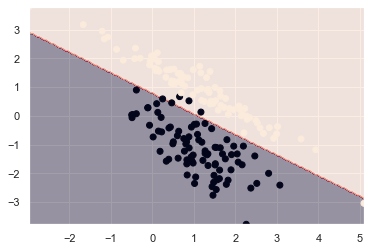

In [329]:
# model = Logit(0, 0, max_iter=10000, tolerance=0.00001, lr=0.01)
model = Logit(0, 0, lr=0.01, max_iter=10000)
y[y == 0] = -1
model.fit(X, y)

plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0, 0.5, 'loss function value')

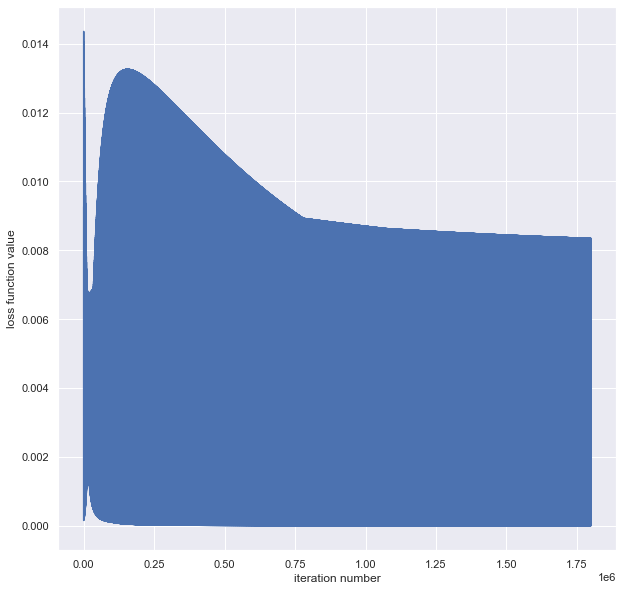

In [330]:
# your code here
plt.figure(1, figsize=(10,10))
plt.plot(model.loss_history)
plt.xlabel("iteration number")
plt.ylabel("loss function value")

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import *

In [ ]:
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:, 1]), ))
    print('\n')
    labels = ['negative', 'positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels,
                yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

In [ ]:
# your code here
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
proba = clf.predict_proba(x_test)
show_results(y_test, prediction, proba)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
clf = SVC(kernel='poly', probability=True)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
proba = clf.predict_proba(x_test)
show_results(y_test, prediction, proba)

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

0. Chosen authors: Chekhov, Dostoevsky, Gogol, Gorky, Lermontov, Turgenev

In [ ]:
import nltk
import string

nltk.download('punkt')

In [ ]:
# 1
# split into sentences

# FIX: ... и названия в начале файлов
def split_sentences(text):
    sentences = np.array(nltk.sent_tokenize(text, language="russian"))
    return sentences


def create_data_frame_from_text(text_path):
    with open(text_path) as f:
        content = f.read()

    sentences = np.array(split_sentences(content))
    myLengthFunc = np.vectorize(len)
    sentences = sentences[np.where(myLengthFunc(sentences) >= 15)]
    author = np.full(sentences.shape[0], authors[text_path.split('/')[1]])
    return pd.DataFrame({'sentence': sentences, 'author': author})

In [ ]:
authors = {
    'Chekhov': 'Чехов',
    'Dostoevsky': 'Достоевский',
    'Gogol': 'Гоголь',
    'Gorky': 'Горький',
    'Turgenev': 'Тургенев',
    'Lermontov': 'Лермонтов'
}

In [ ]:
import glob

data = pd.DataFrame({'sentence': [], 'author': []})
samples_number = [5000, 15000, 8000, 11000, 20000, 3000]

In [ ]:
np.random.seed(42)

i = 0
for author in authors:
    texts = glob.glob(f"prose/{author}/*.txt")
    data_author = pd.DataFrame({'sentence': [], 'author': []})
    for path in texts:
        data_author = pd.concat([data_author, create_data_frame_from_text(path)], ignore_index=True)
    data = pd.concat([data, data_author.sample(n=samples_number[i])], ignore_index=True)
    i = i + 1

In [ ]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# define word tokenizer
word_tokenizer = nltk.WordPunctTokenizer()

dates = [str(x) for x in np.arange(1900, 2022)]

In [ ]:
# 2
import pymorphy2

morph = pymorphy2.MorphAnalyzer()


def process_text(text):
    words = nltk.word_tokenize(text, language='russian')
    tokens = [morph.parse(word.lower())[0].normal_form for word in words if (
                word not in string.punctuation and word not in stop_words and word not in dates and word != '—' and word != '–' and word != '...' and word != '«' and word != '»' and not word.isnumeric())]

    print(words)
    return tokens

In [ ]:

process_text(data.iloc[26028][0])

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


In [ ]:
# your code here

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [ ]:
# your code here